# Understanding Mall customers

https://www.kaggle.com/datark1/customers-clustering-k-means-dbscan-and-ap

In this exercise, you work for a consulting firm as data scientist. In this scenario, your client is the owner of a Mall and he wants to understand the customers who can easily buy.  

You dispose of a dataset from the mall dataset with 5 features :
- CustomerID of the customer
- Gender of the customer
- Age of the customer
- Annual Income of the customer in k$
- Spending Score assigned by the mall based on customer behavior and spending nature (1-99)


You have one day to perform this analysis

## Import Librairies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN

In [3]:
df = pd.read_csv('Mall_Customers.txt')
df = df.drop('CustomerID',axis = 1)

In [4]:
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


# Customer Segmentation using different clustering methods

## Visualisation et traitement

Try to perform different Clustering methods (e.g. k-means, agglomerative, DBSCAN, Gaussian) to create clusters and understand behaviors

https://machinelearningmastery.com/clustering-algorithms-with-python/

https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

### Traitement

In [7]:
df = pd.get_dummies(df, columns=["Gender"], prefix=["sex"])

In [8]:
df = df.astype(float)

In [9]:
df

,Age,Annual Income (k$),Spending Score (1-100),sex_Female,sex_Male
0,19.0,15.0,39.0,0.0,1.0
1,21.0,15.0,81.0,0.0,1.0
2,20.0,16.0,6.0,1.0,0.0
3,23.0,16.0,77.0,1.0,0.0
4,31.0,17.0,40.0,1.0,0.0
...,...,...,...,...,...
195,35.0,120.0,79.0,1.0,0.0
196,45.0,126.0,28.0,1.0,0.0
197,32.0,126.0,74.0,0.0,1.0
198,32.0,137.0,18.0,0.0,1.0


### Visualisation

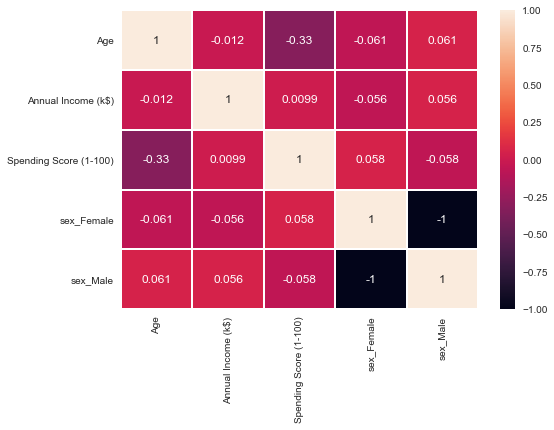

In [8]:
sns.heatmap(df.corr(), annot=True,linewidths=1)
sns.set(rc = {'figure.figsize':(10,5)})

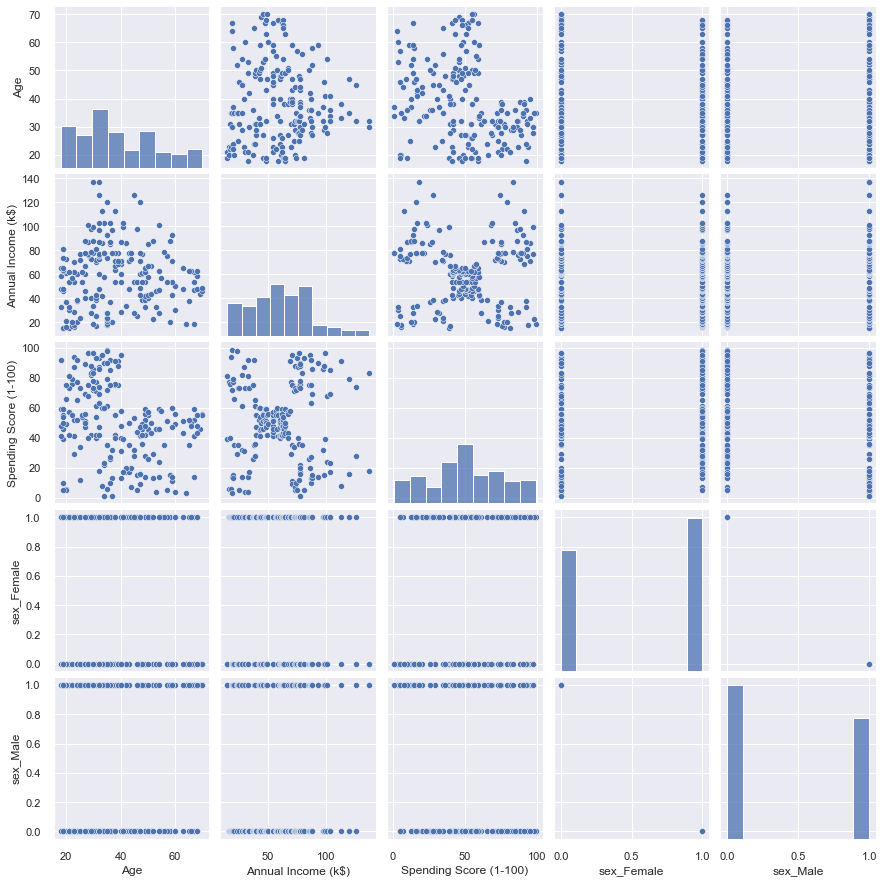

In [9]:
sns.pairplot(df)

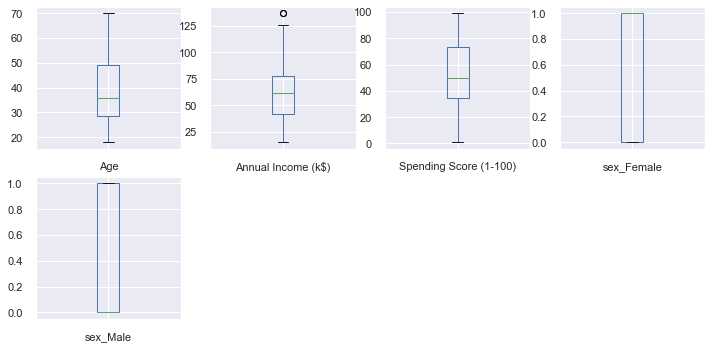

In [10]:
df.plot(kind='box', subplots=True, layout=(4, 4), figsize = (12, 12));

## K-Means

In [15]:
df_km = df.copy()

In [16]:
n_clusters = [2,3,4,5,6,7,8,9,10]
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(df_km)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(df_km, KM_est.labels_)
    s_scores.append(silhouette_avg)

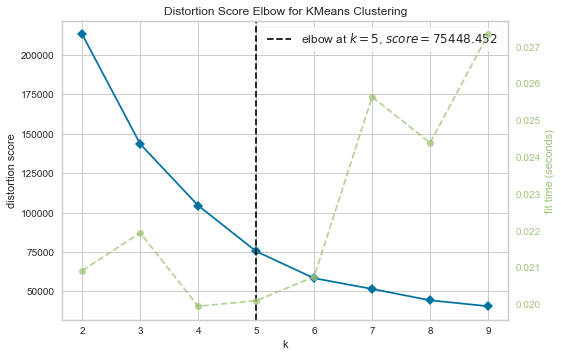

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
model = KMeans(random_state=4)
visualizer = KElbowVisualizer(model, k =(2,10))
visualizer.fit(df_km)
visualizer.show()

In [231]:
km = KMeans(n_clusters=5)
km_pred = km.fit_predict(df_km)

In [232]:
df_km['cluster'] = km_pred
df_km['cluster'].value_counts()
df_km

,Age,Annual Income (k$),Spending Score (1-100),sex_Female,sex_Male,cluster
0,19.0,15.0,39.0,0.0,1.0,3
1,21.0,15.0,81.0,0.0,1.0,4
2,20.0,16.0,6.0,1.0,0.0,3
3,23.0,16.0,77.0,1.0,0.0,4
4,31.0,17.0,40.0,1.0,0.0,3
...,...,...,...,...,...,...
195,35.0,120.0,79.0,1.0,0.0,2
196,45.0,126.0,28.0,1.0,0.0,0
197,32.0,126.0,74.0,0.0,1.0,2
198,32.0,137.0,18.0,0.0,1.0,0


In [263]:
score = silhouette_score(df_km, km.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.444


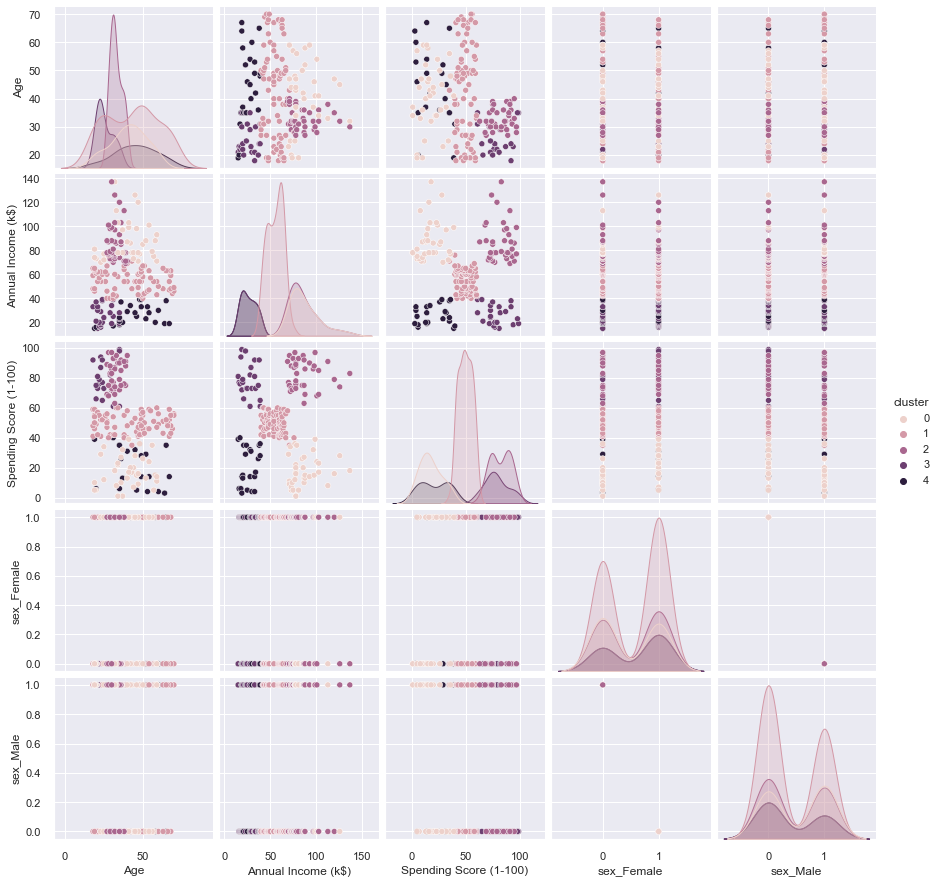

In [190]:
sns.pairplot(df_km, hue = 'cluster')

## Affinity Propagation

In [10]:
df_ap = df.copy()

In [11]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200, random_state=None).fit(df_ap)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(df_ap, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head()

,preference,clusters,sil_score
95,-10500.0,6.0,0.450916
55,-14500.0,6.0,0.450916
94,-10600.0,6.0,0.450916
32,-16800.0,6.0,0.450864
110,-9000.0,6.0,0.450864


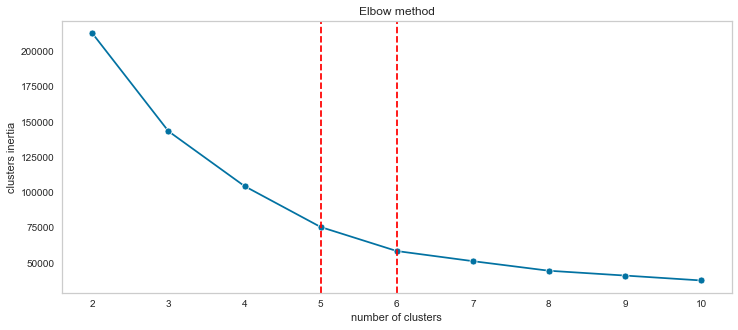

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x = n_clusters,y = clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

In [19]:
ap = AffinityPropagation(preference=-14500,random_state=None)
ap_pred = ap.fit_predict(df_ap)

In [92]:
df_ap['cluster'] = ap_pred
df_ap['cluster'].value_counts()

3    47
5    39
2    38
4    34
0    21
1    21
Name: cluster, dtype: int64

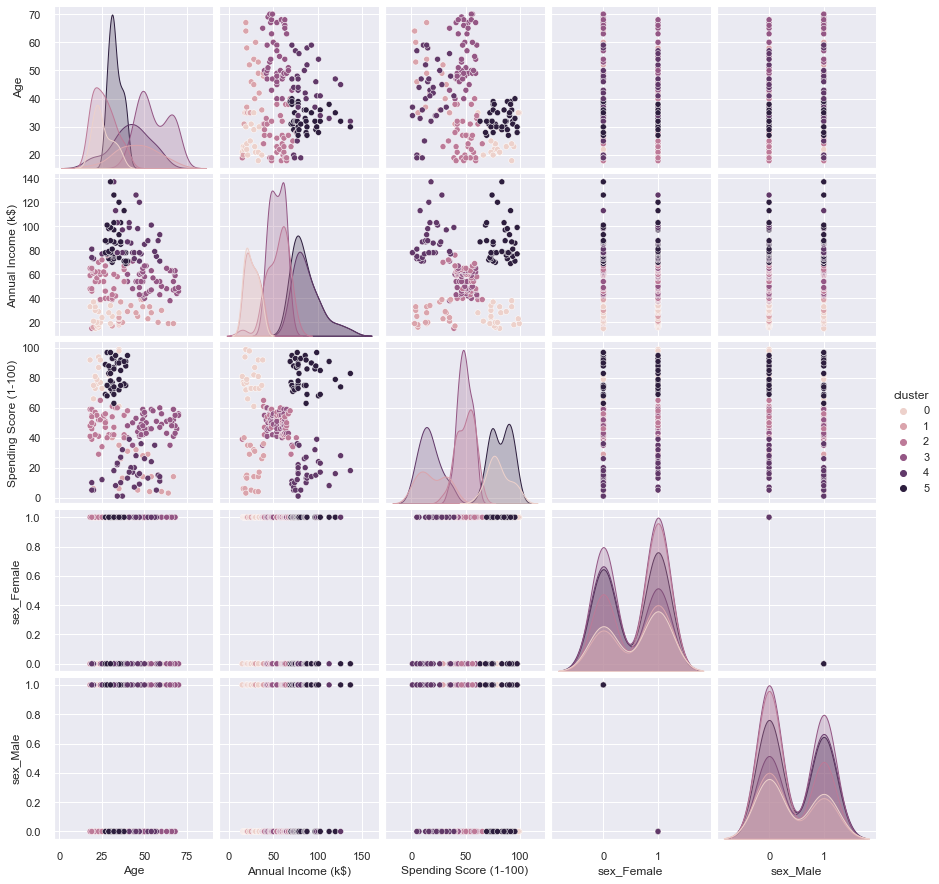

In [102]:
sns.pairplot(df_ap,hue = 'cluster')

## DBSCAN

In [108]:
df_scan = df.copy()

In [93]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [94]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_scan)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(df_scan, DBS_clustering.labels_))

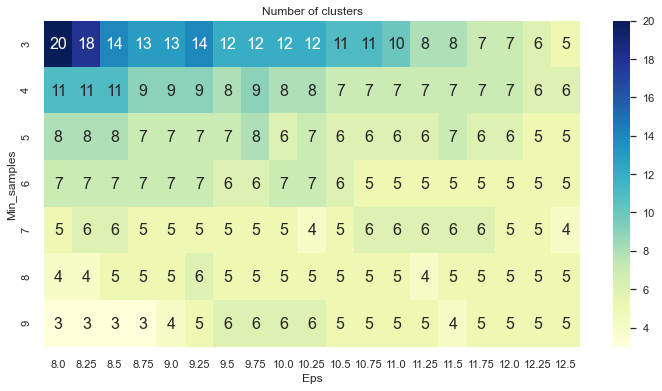

In [97]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

In [99]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(df_scan)

DBSCAN_clustered = df_scan.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_

In [100]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,22
0,109
1,8
2,34
3,23
4,4


C:\Users\mattb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mattb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


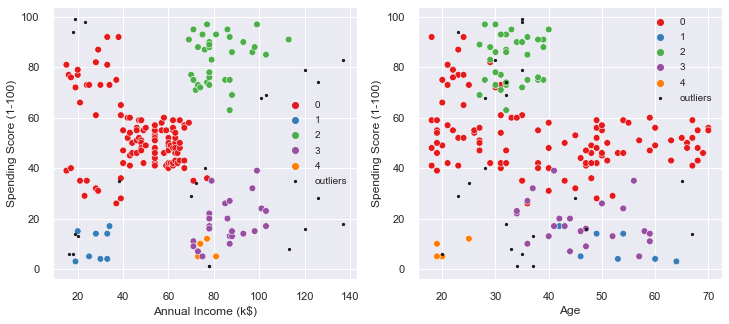

In [101]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()


In [109]:
scan = DBSCAN(eps=12.5, min_samples=4)
df_scan

,Age,Annual Income (k$),Spending Score (1-100),sex_Female,sex_Male
0,19.0,15.0,39.0,0.0,1.0
1,21.0,15.0,81.0,0.0,1.0
2,20.0,16.0,6.0,1.0,0.0
3,23.0,16.0,77.0,1.0,0.0
4,31.0,17.0,40.0,1.0,0.0
...,...,...,...,...,...
195,35.0,120.0,79.0,1.0,0.0
196,45.0,126.0,28.0,1.0,0.0
197,32.0,126.0,74.0,0.0,1.0
198,32.0,137.0,18.0,0.0,1.0


In [111]:
scan_pred = scan.fit_predict(df_scan)
df_scan['cluster'] = scan_pred

In [112]:
df_scan['cluster'].value_counts()

 0    112
 2     34
 3     24
-1     18
 1      8
 4      4
Name: cluster, dtype: int64

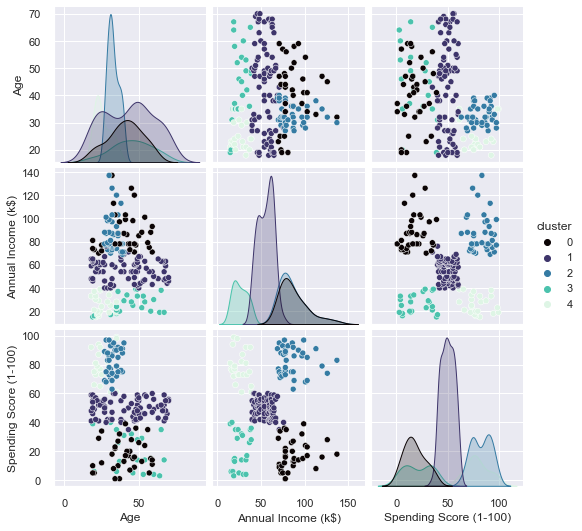

In [241]:
sns.pairplot(df_km.drop(['sex_Female','sex_Male'],axis=1),hue = 'cluster',palette = 'mako')

# Conclusions

## cluster interpretation

In [226]:
df_km

,Age,Annual Income (k$),Spending Score (1-100),sex_Female,sex_Male,cluster
0,19.0,15.0,39.0,0.0,1.0,4
1,21.0,15.0,81.0,0.0,1.0,3
2,20.0,16.0,6.0,1.0,0.0,4
3,23.0,16.0,77.0,1.0,0.0,3
4,31.0,17.0,40.0,1.0,0.0,4
...,...,...,...,...,...,...
195,35.0,120.0,79.0,1.0,0.0,2
196,45.0,126.0,28.0,1.0,0.0,1
197,32.0,126.0,74.0,0.0,1.0,2
198,32.0,137.0,18.0,0.0,1.0,1


<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

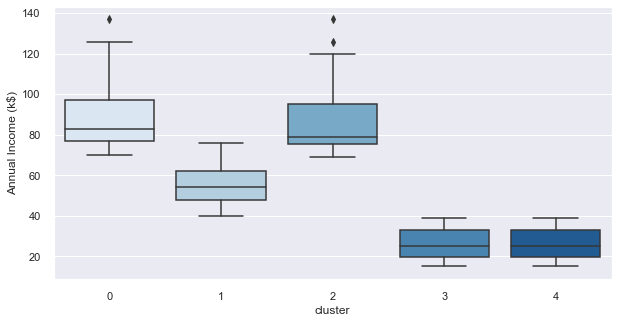

In [234]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.boxplot(y='Annual Income (k$)',x='cluster', data=df_km, palette="Blues")

<AxesSubplot:xlabel='cluster', ylabel='Age'>

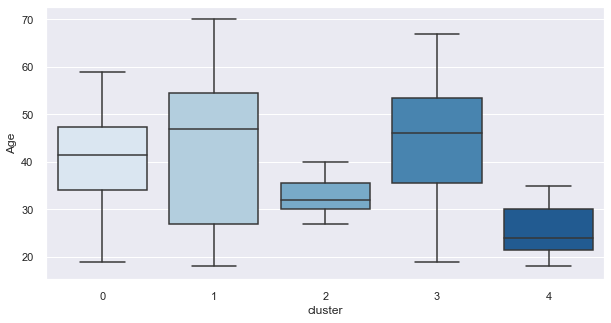

In [235]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.boxplot(y='Age',x='cluster', data=df_km, palette="Blues")

<AxesSubplot:xlabel='cluster', ylabel='Spending Score (1-100)'>

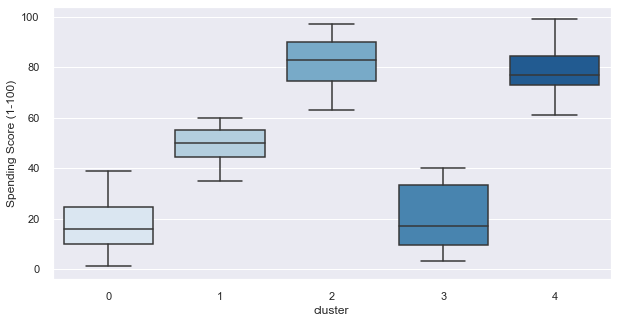

In [236]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.boxplot(y='Spending Score (1-100)',x='cluster', data=df_km, palette="Blues")

In [237]:
df_km_corr = pd.get_dummies(df_km, columns=["cluster"], prefix=["cluster"])

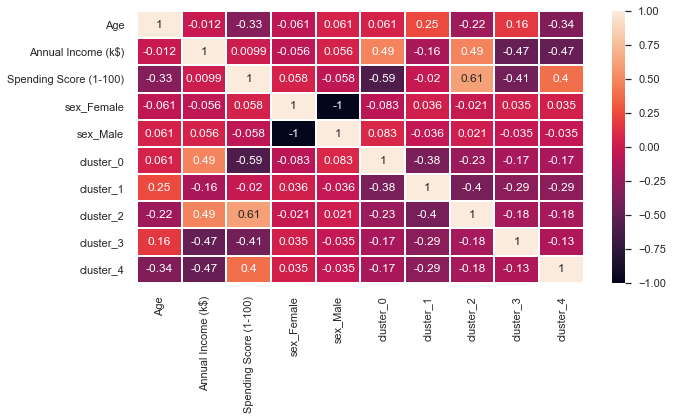

In [238]:
sns.heatmap(df_km_corr.corr(), annot=True,linewidths=1)
sns.set(rc = {'figure.figsize':(10,5)})

In [257]:
df_km['cluster'].value_counts(normalize=True)*100

1    39.5
2    19.5
0    18.0
3    11.5
4    11.5
Name: cluster, dtype: float64

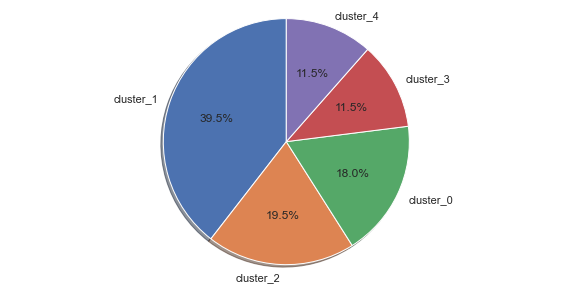

In [261]:
labels = ['cluster_1','cluster_2','cluster_0','cluster_3','cluster_4']
sizes = df_km['cluster'].value_counts()
explode = (0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()